In [1]:
import sys
sys.path.append("..")
import os
os.chdir("..")
import comet_ml
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import torch
from monai.transforms import (
    Compose,
    LoadImage,
    Orientation,
    CropForeground,
    Resize,
    ScaleIntensity,
    Transform,
    SpatialPad
)
from monai.data import CacheDataset, DataLoader, ZipDataset

from neuro_ix.datasets.mriqc_dataset import MIDLMRArtDataset
api = comet_ml.API(
            api_key="WmA69YL7Rj2AfKqwILBjhJM3k"
        )
def threshold_one(x):
    return x >= 0.01

/opt/anaconda/envs/bowl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Get Dataset

In [3]:
imshape = (1, 160, 192, 160)
ds = MIDLMRArtDataset("/home/at70870/narval/scratch",  score_path="data-test/MRIQC/derivatives/scores.csv")
test_path= ds.get_test_path()
test_scores = list(map(lambda x: int(ds.dataset_score(x))-1, test_path))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
transform = Compose(
            [
                LoadImage(ensure_channel_first=True, image_only=True),
                Orientation(axcodes="RAS"),
                ScaleIntensity(0, 1),
                CropForeground(threshold_one, allow_smaller=True),
                Resize(( 160, 192, 160)),
            ]
        )
val_ds = CacheDataset(data=test_path, transform=transform, num_workers=10)
val_loader = DataLoader(ZipDataset([val_ds, test_scores]), batch_size=20)
len(test_scores)

Loading dataset: 100%|██████████| 89/89 [00:39<00:00,  2.23it/s]


89

## Get Models

In [4]:
from neuro_ix.models.baseline import BaselineModel
from neuro_ix.models.rnn_cnn import RNNCNN
from neuro_ix.models.augmented_cnn import AugBaselineModel
from neuro_ix.models.naive_res import RNNCNN as NaiveRNN
from sklearn.metrics import accuracy_score, confusion_matrix
from neuro_ix.utils.score import analyse_classif
import glob


In [66]:
experiments = api.get("cbricout", "midl2024")
experiments

[<APIExperiment 'cbricout/midl2024/b128ba24c69743168641d05f2f858c41'>,
 <APIExperiment 'cbricout/midl2024/bcc6dab39fae484294ba399e2becb2d5'>,
 <APIExperiment 'cbricout/midl2024/9c0b75eca72640c38ba29ee97c47cff1'>,
 <APIExperiment 'cbricout/midl2024/66e77cce966c48229218514016beb4f8'>,
 <APIExperiment 'cbricout/midl2024/577b5388ef1e4806a11af9ff8a79ce52'>,
 <APIExperiment 'cbricout/midl2024/cbca38a0a8274bdcaf8b44aa7f0819f9'>,
 <APIExperiment 'cbricout/midl2024/66828e809d454272b3c361b93440ce44'>,
 <APIExperiment 'cbricout/midl2024/d4ebdff182a648a5b283c95ecb0a44e5'>,
 <APIExperiment 'cbricout/midl2024/cef004164ebd4effa88c5bff5790da28'>,
 <APIExperiment 'cbricout/midl2024/9ec3e77a9a4342d19fd7fc0e21e8afdc'>,
 <APIExperiment 'cbricout/midl2024/f3df7a60b90f40e684627f69924fb31c'>,
 <APIExperiment 'cbricout/midl2024/37253dd1673645faa894416bd32da127'>,
 <APIExperiment 'cbricout/midl2024/d7c30dd23d0c4e9da9867ab94fb56e07'>,
 <APIExperiment 'cbricout/midl2024/9d5e60b2814149dc909fdb722c328f3e'>,
 <APIE

In [67]:
def test_exp(exp:comet_ml.APIExperiment):
    plt.clf()
    mod_name=exp.get_model_names()[0]
    exp_name = exp.name.replace("-lr1e-05","")
    exp.download_model(mod_name, output_path="current")
    use_dec = not "NoDec" in mod_name
    if "Baseline" in mod_name:
        model = BaselineModel(1,imshape, use_decoder=use_dec)
    elif 'Augmented' in mod_name:
        model = AugBaselineModel(1, imshape, use_decoder=use_dec)
    elif 'RNN' in mod_name:
        model = RNNCNN(1, imshape, use_decoder=use_dec)
    elif 'NaiveRes' in mod_name:
        model = NaiveRNN(1, imshape, use_decoder=use_dec)
    model.load_state_dict(torch.load("current/model-data/comet-torch-model.pth"))
    

    model.to(device)
    model.eval()
    pred=[]
    label=[]
    with torch.no_grad():
        for x,y in val_loader:
            x=x.to(device)
            _,_, classe=model(x)
            pred+=classe.argmax(dim=1).cpu().tolist()
            label+=y.tolist()
    
    accs = analyse_classif(label, pred)
    run_num = len(glob.glob(f'fig_test/{exp_name}-conf*'))
    plt.tight_layout()
    plt.savefig(f'fig_test/{exp_name}-conf-{run_num+1}.png')
    return (exp_name, run_num+1, accuracy_score(label, pred), *accs)

COMET INFO: Downloading experiment model 'Baseline' ...


COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


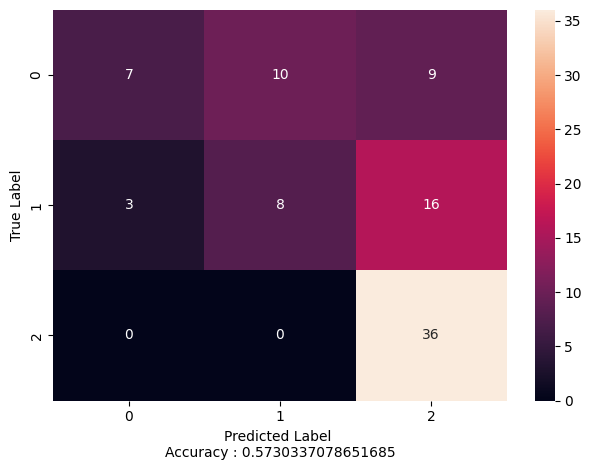

In [68]:
test_accs = []
for expm in experiments:
    test_accs.a.ppend(test_exp(expm))
res_df = pd.DataFrame(test_accs, columns=['model', 'sit', 'accuracy', 'acc1', 'acc2', 'acc3'])

In [21]:
model = RNNCNN(1, imshape, use_decoder=True)
model.load_state_dict(torch.load("current/model-data/comet-torch-model.pth"))

450


<All keys matched successfully>

In [69]:
res_df.sort_values(['model', 'sit'])

,model,sit,accuracy,acc1,acc2,acc3
10,Augmented-NoDec-beta1.0,1,0.685393,0.923077,0.148148,0.916667
15,Augmented-NoDec-beta1.0,2,0.651685,0.923077,0.148148,0.833333
16,Augmented-NoDec-beta1.0,3,0.584270,0.538462,0.148148,0.944444
19,Augmented-NoDec-beta1.0,4,0.584270,0.576923,0.148148,0.916667
28,Augmented-NoDec-beta1.0,5,0.595506,0.500000,0.185185,0.972222
14,Augmented-beta0.01,1,0.606742,0.346154,0.444444,0.916667
17,Augmented-beta0.01,2,0.662921,0.884615,0.037037,0.972222
27,Augmented-beta0.01,3,0.640449,0.923077,0.111111,0.833333
34,Augmented-beta0.01,4,0.595506,0.653846,0.148148,0.888889
36,Augmented-beta0.01,5,0.651685,0.769231,0.407407,0.750000


In [71]:
aggregated=res_df.groupby(by="model").agg( {'accuracy':['mean','std', 'max'],'acc1':['mean','std', 'max'],'acc2':['mean','std', 'max'],'acc3':['mean','std', 'max']})
aggregated=aggregated*100
aggregated=aggregated.round(1)
aggregated

accuracy             acc1               acc2        \
                            mean  std   max  mean   std    max  mean   std   
model                                                                        
Augmented-NoDec-beta1.0     62.0  4.6  68.5  69.2  21.2   92.3  15.6   1.7   
Augmented-beta0.01          63.1  2.9  66.3  71.5  23.2   92.3  23.0  18.4   
Augmented-beta1.0           67.6  2.4  69.7  91.5   8.8  100.0  22.2  20.1   
Baseline                    63.1  2.0  65.2  82.3  11.1   96.2  11.1   6.9   
Baseline-NoDec              61.1  2.7  64.0  62.3  21.0   80.8  23.7   8.9   
Baseline-beta0.01           58.9  3.9  64.0  63.8  24.9   92.3   8.1   9.2   
NaiveRes-NoDec-beta1.0      64.3  4.9  69.7  80.0  24.7  100.0  14.8   3.7   
NaiveRes-beta0.01           66.1  2.7  69.7  84.6   9.0   96.2  19.3   9.2   
NaiveRes-beta1.0            63.1  4.5  67.4  80.8   9.0   88.5   8.9   6.2   
RNN-NoDec-beta1.0           62.2  7.4  69.7  68.5  11.3   80.8  23.0  15.6   
RNN-beta0.01                64.5  3.9  69.7  68.5  19.3   84.6  27.4  15.0   
RNN-beta1.0                 58.7  7.2  66.3  63.1  19.0   84.6  16.3  17.9   

                               acc3               
                          max  mean   std    max  
model                                             
Augmented-NoDec-beta1.0  18.5  91.7   5.2   97.2  
Augmented-beta0.01       44.4  87.2   8.5   97.2  
Augmented-beta1.0        48.1  84.4   5.4   91.7  
Baseline                 18.5  88.3   4.6   91.7  
Baseline-NoDec           33.3  88.3   7.2  100.0  
Baseline-beta0.01        22.2  93.3   6.7  100.0  
NaiveRes-NoDec-beta1.0   18.5  90.0   8.7   97.2  
NaiveRes-beta0.01        25.9  87.8   9.9   97.2  
NaiveRes-beta1.0         14.8  91.1   6.3   97.2  
RNN-NoDec-beta1.0        40.7  87.2   7.5   94.4  
RNN-beta0.01             48.1  89.4   6.0   97.2  
RNN-beta1.0              44.4  87.2  10.1  100.0

In [15]:
for line in aggregated.iterrows():
    metrics = line[1]
    line = f"{line[0]} & ${metrics['accuracy']['mean']}\\pm{metrics['accuracy']['std']}\\%$"
    line += f"& ${metrics['acc1']['mean']}\\pm{metrics['acc1']['std']}\\%$"
    line += f"& ${metrics['acc2']['mean']}\\pm{metrics['acc2']['std']}\\%$"
    line += f"& ${metrics['acc3']['mean']}\\pm{metrics['acc3']['std']}\\%$\\\\"
    print(line)


Augmented-NoDec-beta1.0 & $62.0\pm4.6\%$& $69.2\pm21.2\%$& $15.6\pm1.7\%$& $91.7\pm5.2\%$\\
Augmented-beta0.01 & $63.1\pm2.9\%$& $71.5\pm23.2\%$& $23.0\pm18.4\%$& $87.2\pm8.5\%$\\
Augmented-beta1.0 & $67.6\pm2.4\%$& $91.5\pm8.8\%$& $22.2\pm20.1\%$& $84.4\pm5.4\%$\\
Baseline & $63.1\pm2.0\%$& $82.3\pm11.1\%$& $11.1\pm6.9\%$& $88.3\pm4.6\%$\\
Baseline-NoDec & $57.8\pm9.8\%$& $56.9\pm32.6\%$& $17.8\pm12.9\%$& $88.3\pm7.2\%$\\
Baseline-beta0.01 & $58.9\pm3.9\%$& $63.8\pm24.9\%$& $8.1\pm9.2\%$& $93.3\pm6.7\%$\\
NaiveRes-NoDec-beta1.0 & $64.3\pm4.9\%$& $80.0\pm24.7\%$& $14.8\pm3.7\%$& $90.0\pm8.7\%$\\
NaiveRes-beta0.01 & $66.1\pm2.7\%$& $84.6\pm9.0\%$& $19.3\pm9.2\%$& $87.8\pm9.9\%$\\
NaiveRes-beta1.0 & $63.1\pm4.5\%$& $80.8\pm9.0\%$& $8.9\pm6.2\%$& $91.1\pm6.3\%$\\
RNN-NoDec-beta1.0 & $62.2\pm7.4\%$& $68.5\pm11.3\%$& $23.0\pm15.6\%$& $87.2\pm7.5\%$\\
RNN-beta0.01 & $60.7\pmnan\%$& $30.8\pmnan\%$& $51.9\pmnan\%$& $88.9\pmnan\%$\\
RNN-beta1.0 & $58.7\pm7.2\%$& $63.1\pm19.0\%$& $16.3\pm17.9\%$

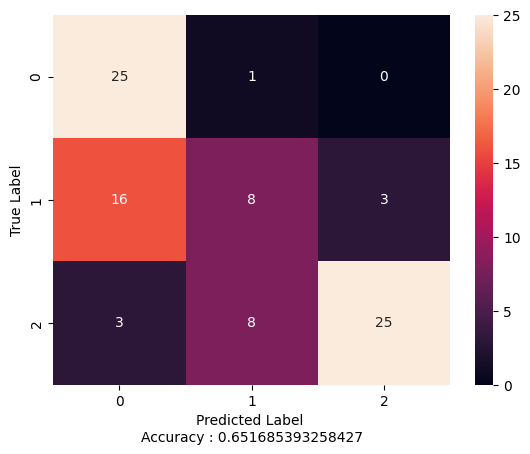

In [ ]:
analyse_classif(label, pred)

# Test Binary Classif

In [ ]:
def test_exp_bin(exp:comet_ml.APIExperiment):
    plt.clf()
    mod_name=exp.get_model_names()[0]

    exp.download_model(mod_name, output_path="current")
    use_dec = not "NoDec" in mod_name
    if "Baseline" in mod_name:
        model = BaselineModel(1,imshape, use_decoder=use_dec)
    elif 'Augmented' in mod_name:
        model = AugBaselineModel(1, imshape, use_decoder=use_dec)
    elif 'RNN' in mod_name:
        model = RNNCNN(1, imshape, use_decoder=use_dec)
    elif 'NaiveRes' in mod_name:
        model = NaiveRNN(1, imshape, use_decoder=use_dec)
    model.load_state_dict(torch.load("current/model-data/comet-torch-model.pth"))
    model.to(device)
    model.eval()
    pred=[]
    label=[]
    with torch.no_grad():
        for x,y in val_loader:
            x=x.to(device)
            _,_, classe=model(x)
            pred+=(classe.argmax(dim=1)<2).cpu().tolist()
            label+=(y<2).tolist()
    
    accs = analyse_classif(label, pred)
    run_num = len(glob.glob(f'fig_test_bin/{mod_name}-conf*'))
    plt.tight_layout()
    plt.savefig(f'fig_test_bin/{mod_name}-conf-{run_num+1}')
    return (f"{mod_name}", run_num+1, accuracy_score(label, pred), *accs)

COMET INFO: Downloading experiment model 'Baseline-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes-NoDec' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN' ...
COMET INFO: Unzipping model to 'current' ...
COMET INFO: done!


450


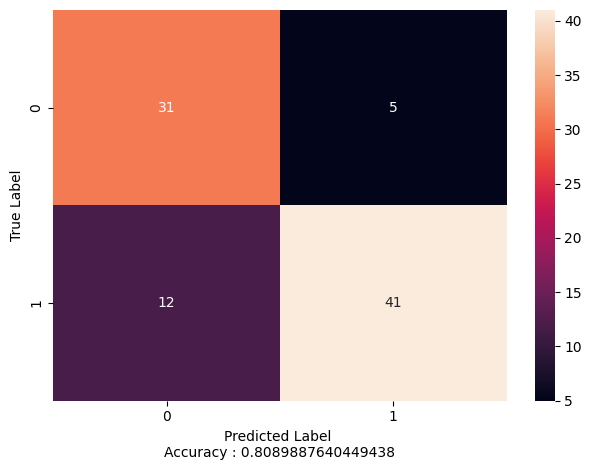

In [ ]:
test_accs = []
for expm in experiments:
    test_accs.append(test_exp_bin(expm))
res_df = pd.DataFrame(test_accs, columns=['model', 'sit', 'accuracy', 'acc1', 'acc2'])

In [88]:
res_df.sort_values(['model', 'sit'])

,model,sit,accuracy,acc1,acc2,acc3,split,name,kind,beta,rename
10,Augmented-NoDec-beta1.0,1,0.685393,0.923077,0.148148,0.916667,"[Augmented, NoDec, beta1.0]",Augmented,NoDec,NoDec,Base+DO
15,Augmented-NoDec-beta1.0,2,0.651685,0.923077,0.148148,0.833333,"[Augmented, NoDec, beta1.0]",Augmented,NoDec,NoDec,Base+DO
16,Augmented-NoDec-beta1.0,3,0.584270,0.538462,0.148148,0.944444,"[Augmented, NoDec, beta1.0]",Augmented,NoDec,NoDec,Base+DO
19,Augmented-NoDec-beta1.0,4,0.584270,0.576923,0.148148,0.916667,"[Augmented, NoDec, beta1.0]",Augmented,NoDec,NoDec,Base+DO
28,Augmented-NoDec-beta1.0,5,0.595506,0.500000,0.185185,0.972222,"[Augmented, NoDec, beta1.0]",Augmented,NoDec,NoDec,Base+DO
14,Augmented-beta0.01,1,0.606742,0.346154,0.444444,0.916667,"[Augmented, beta0.01]",Augmented,0.01,0.01,Base+DO
17,Augmented-beta0.01,2,0.662921,0.884615,0.037037,0.972222,"[Augmented, beta0.01]",Augmented,0.01,0.01,Base+DO
27,Augmented-beta0.01,3,0.640449,0.923077,0.111111,0.833333,"[Augmented, beta0.01]",Augmented,0.01,0.01,Base+DO
34,Augmented-beta0.01,4,0.595506,0.653846,0.148148,0.888889,"[Augmented, beta0.01]",Augmented,0.01,0.01,Base+DO
36,Augmented-beta0.01,5,0.651685,0.769231,0.407407,0.750000,"[Augmented, beta0.01]",Augmented,0.01,0.01,Base+DO


In [90]:
aggregated=res_df.groupby(by=["rename", "beta"]).agg( {'accuracy':['mean','std', 'max'],'acc1':['mean','std', 'max'],'acc2':['mean','std', 'max']})
aggregated=aggregated*100
aggregated=aggregated.round(1)
aggregated

accuracy             acc1               acc2            
                     mean  std   max  mean   std    max  mean   std   max
rename     beta                                                          
Base       0.01      58.9  3.9  64.0  63.8  24.9   92.3   8.1   9.2  22.2
           1.0       63.1  2.0  65.2  82.3  11.1   96.2  11.1   6.9  18.5
           NoDec     61.1  2.7  64.0  62.3  21.0   80.8  23.7   8.9  33.3
Base+DO    0.01      63.1  2.9  66.3  71.5  23.2   92.3  23.0  18.4  44.4
           1.0       67.6  2.4  69.7  91.5   8.8  100.0  22.2  20.1  48.1
           NoDec     62.0  4.6  68.5  69.2  21.2   92.3  15.6   1.7  18.5
BaseRes    0.01      66.1  2.7  69.7  84.6   9.0   96.2  19.3   9.2  25.9
           1.0       63.1  4.5  67.4  80.8   9.0   88.5   8.9   6.2  14.8
           NoDec     64.3  4.9  69.7  80.0  24.7  100.0  14.8   3.7  18.5
PatchedRes 0.01      64.5  3.9  69.7  68.5  19.3   84.6  27.4  15.0  48.1
           1.0       58.7  7.2  66.3  63.1  19.0   84.6  16.3  17.9  44.4
           NoDec     62.2  7.4  69.7  68.5  11.3   80.8  23.0  15.6  40.7

In [91]:
for line in aggregated.iterrows():
    metrics = line[1]
    line = f"{line[0][0]} & {line[0][1]} & ${metrics['accuracy']['mean']} & \\pm{metrics['accuracy']['max']}\\%$"
    print(line)


('Base', '0.01') & $58.9\pm3.9\%$
('Base', '1.0') & $63.1\pm2.0\%$
('Base', 'NoDec') & $61.1\pm2.7\%$
('Base+DO', '0.01') & $63.1\pm2.9\%$
('Base+DO', '1.0') & $67.6\pm2.4\%$
('Base+DO', 'NoDec') & $62.0\pm4.6\%$
('BaseRes', '0.01') & $66.1\pm2.7\%$
('BaseRes', '1.0') & $63.1\pm4.5\%$
('BaseRes', 'NoDec') & $64.3\pm4.9\%$
('PatchedRes', '0.01') & $64.5\pm3.9\%$
('PatchedRes', '1.0') & $58.7\pm7.2\%$
('PatchedRes', 'NoDec') & $62.2\pm7.4\%$


In [74]:

def get_kind(name:str):
    if 'NoDec' in name:
        return "NoDec"
    elif "beta" in name:
        be =name.find("beta")
        return name[be+4:]
    else :
        return "1.0"
    
res_df['split']=res_df['model'].str.split('-')
res_df['name']=res_df['split'].apply(lambda x:x[0])
res_df['beta']=res_df['model'].apply(get_kind)


res_df

,model,sit,accuracy,acc1,acc2,acc3,split,name,kind,beta
0,Baseline,1,0.606742,0.730769,0.074074,0.916667,[Baseline],Baseline,1.0,1.0
1,Baseline-NoDec,1,0.640449,0.615385,0.333333,0.888889,"[Baseline, NoDec]",Baseline,NoDec,NoDec
2,Baseline-NoDec,2,0.617978,0.807692,0.185185,0.805556,"[Baseline, NoDec]",Baseline,NoDec,NoDec
3,Baseline-NoDec,3,0.595506,0.730769,0.111111,0.861111,"[Baseline, NoDec]",Baseline,NoDec,NoDec
4,Baseline,2,0.617978,0.961538,0.037037,0.805556,[Baseline],Baseline,1.0,1.0
5,Baseline,3,0.651685,0.923077,0.074074,0.888889,[Baseline],Baseline,1.0,1.0
6,Baseline-NoDec,4,0.629213,0.692308,0.259259,0.861111,"[Baseline, NoDec]",Baseline,NoDec,NoDec
7,Baseline,4,0.629213,0.730769,0.185185,0.888889,[Baseline],Baseline,1.0,1.0
8,Baseline,5,0.651685,0.769231,0.185185,0.916667,[Baseline],Baseline,1.0,1.0
9,NaiveRes-NoDec-beta1.0,1,0.561798,0.384615,0.185185,0.972222,"[NaiveRes, NoDec, beta1.0]",NaiveRes,NoDec,NoDec


In [77]:
rename={'Baseline':'Base', 'Augmented':"Base+DO", 'NaiveRes':'BaseRes', 'RNN':'PatchedRes'}
res_df['rename']=res_df['name'].apply(lambda x : rename[x])

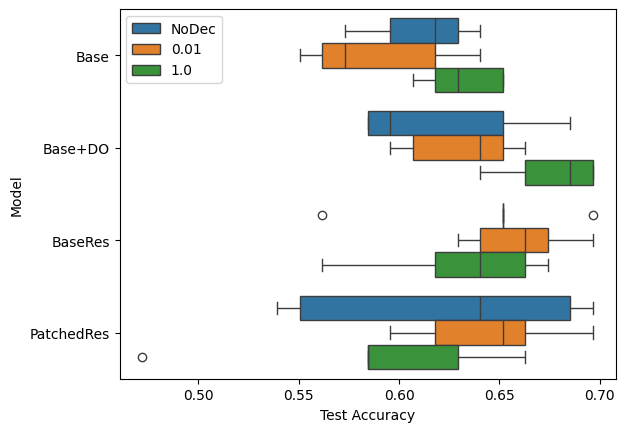

In [87]:
sb.boxplot(res_df.sort_values(['model', 'sit']), y="rename", x="accuracy", hue="beta", order=['Base',"Base+DO",'BaseRes','PatchedRes'])
plt.ylabel("Model")
plt.xlabel("Test Accuracy")
plt.legend(loc="upper left")


<Axes: xlabel='accuracy', ylabel='model'>

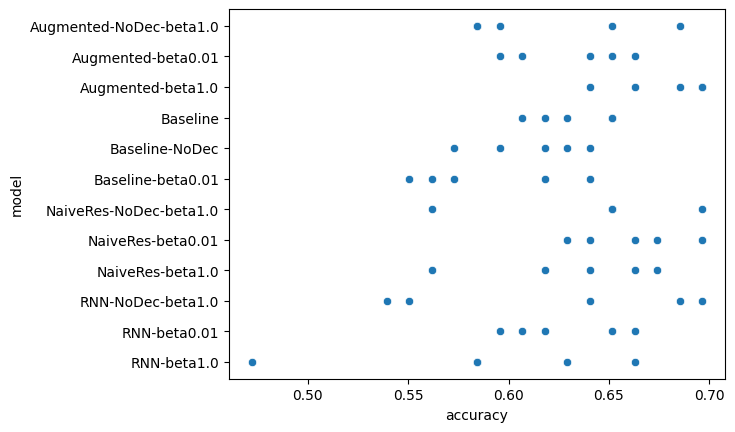

In [50]:
sb.scatterplot(res_df.sort_values(['model', 'sit']), y="model", x="accuracy",)
